# Notes
### Comments
    - I'm now using LR 2e-3
    - 

### ToDo
    - Try bigger attribute (>1) with final model
    - Select other attr (prefer balanced)
    - Compare the influence flipping attr with/without discriminator
    - Experiments on inputting attr only at first layer of Dec
    - Comparing with other model IcGan (Do we need to do this?)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
import skimage.transform

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from src.celeba_dataset import CelebA
from src.fadernet import Encoder,Decoder,Discriminator
%matplotlib inline

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(SEED)


data_path = 'data/img/'
spliting_path = '/home/alexliu/Downloads/CelebA/Eval/list_eval_partition.txt'
attribute_path = '/home/alexliu/Downloads/CelebA/Anno/list_attr_celeba.txt'



# Training Config
use_cpu_cores = 8
num_epoch = 500
display_step = 50
plot_step = 500
batch_size = 32
LEARNING_RATE = 2e-3
betas=(0.5, 0.999)
final_lambda = 1e-4
increase_step = 500000
increase_lambda = final_lambda/increase_step

# Logger & Debug
num_test_fig = 10
save_fig = True
save_fig_path = 'fig/debug_step_{}.jpg'
step_msg = 'Epoch {}\tGlobStep {}\tMSE {:.4f}\tBCE {:.4f}\tadv {:.4f}\t'

save_model = True
save_model_interval = 10000
save_model_path = 'checkpoint/first_version'

# Model Config
target_attr = 'Smiling'
k_list = [3, 16, 32, 64, 128, 256, 512, 512]
IMAGE_SIZE = 256
num_tags = 2

# Load Dataset

Currently using single attribute

In [2]:
# Read the Attribute table & split dataset
attri_table = pd.read_csv(attribute_path,sep=' * ',skiprows=1)
split = pd.read_csv(spliting_path,header=None,sep=' ',index_col=0)
split = split.rename(columns={1:'Set'}).join(attri_table[target_attr])
split[target_attr] = split[target_attr]==1



# Read the spliting table & split dataset

train_set = [(idx.split('.')[0]+'.png',[1*row[target_attr],1*(not row[target_attr])]) 
             for idx,row in split.loc[split['Set']==0].iterrows()]
valid_set = [(idx.split('.')[0]+'.png',[1*row[target_attr],1*(not row[target_attr])]) 
             for idx,row in split.loc[split['Set']==1].iterrows()]
test_set = [(idx.split('.')[0]+'.png',[1*row[target_attr],1*(not row[target_attr])]) 
             for idx,row in split.loc[split['Set']==2].iterrows()]


# Create Dataset
train_set = DataLoader(CelebA(train_set,data_path), 
                       batch_size=batch_size, shuffle=True, num_workers=use_cpu_cores, drop_last=True)
debug_set = DataLoader(CelebA(test_set[:num_test_fig],data_path), 
                       batch_size=num_test_fig, shuffle=False, num_workers=1, drop_last=False)

print('Training 1 epoch =',len(train_set),'steps')
print('Training for',num_epoch*len(train_set),'steps')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Training 1 epoch = 5086 steps
Training for 2543000 steps


# Load model

In [ ]:
input_img = Variable(torch.zeros(batch_size, 3, IMAGE_SIZE, IMAGE_SIZE).float(),requires_grad=False)
given_attr = Variable(torch.zeros(batch_size, num_tags),requires_grad=False)
flipped_attr = Variable(torch.zeros(batch_size, num_tags),requires_grad=False)

test_img = Variable(torch.zeros(num_test_fig, 3, IMAGE_SIZE, IMAGE_SIZE).float(),requires_grad=False)
test_attr = Variable(torch.zeros(num_test_fig, num_tags),requires_grad=False)

enc = Encoder(k_list)
dec = Decoder(k_list, num_tags, image_size=IMAGE_SIZE)
dis = Discriminator(num_tags)

reconstruct_loss = nn.MSELoss()
classification_loss = nn.BCEWithLogitsLoss()

if use_cuda:
    input_img = input_img.cuda()
    given_attr = given_attr.cuda()
    flipped_attr = flipped_attr.cuda()
    test_img = test_img.cuda()
    test_attr = test_attr.cuda()
    enc = enc.cuda()
    dec = dec.cuda()
    reconstruct_loss = reconstruct_loss.cuda()
    classification_loss = classification_loss.cuda()
    dis = dis.cuda()

opt_enc_dec = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=LEARNING_RATE, betas=betas)
opt_dis = optim.Adam(dis.parameters(), lr=LEARNING_RATE, betas=betas)

# Train model

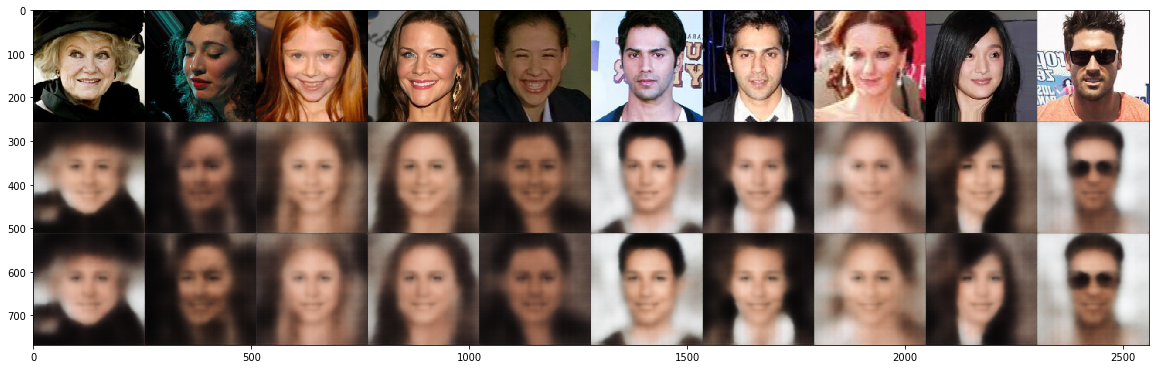

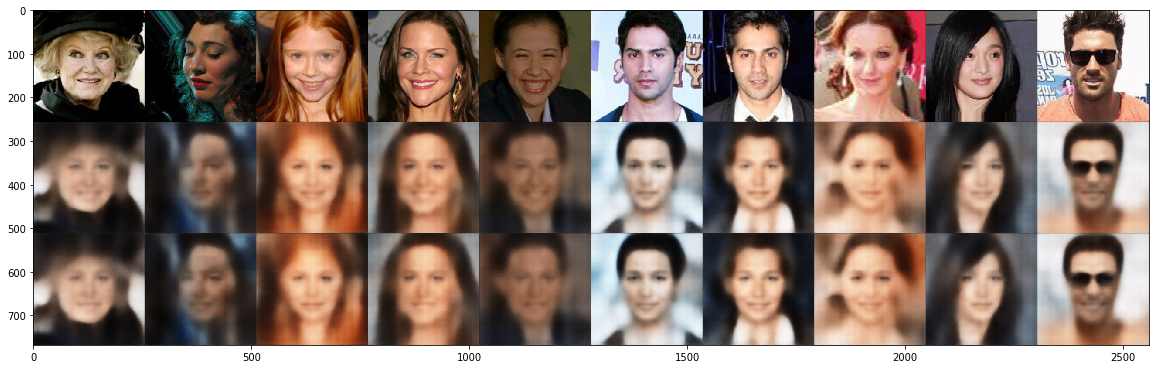

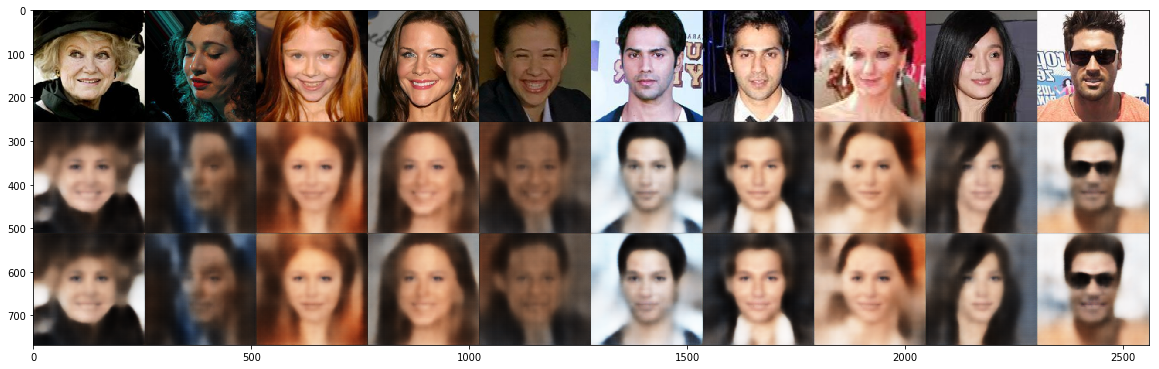

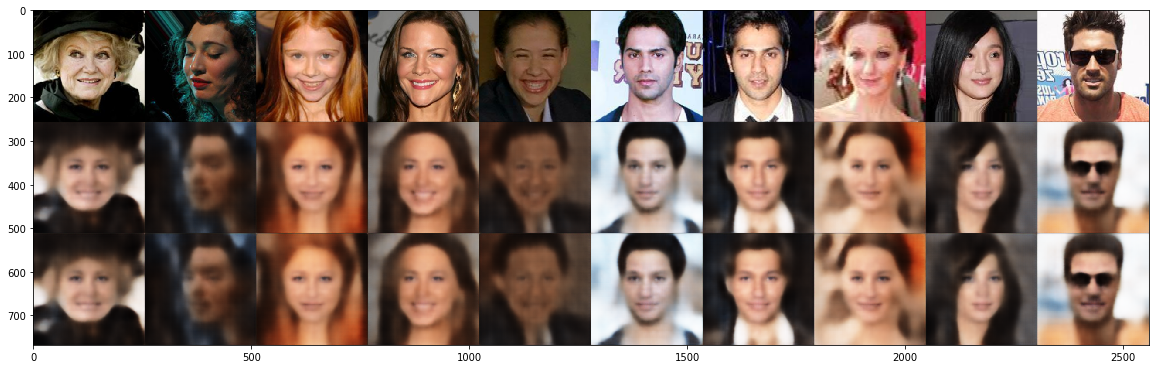

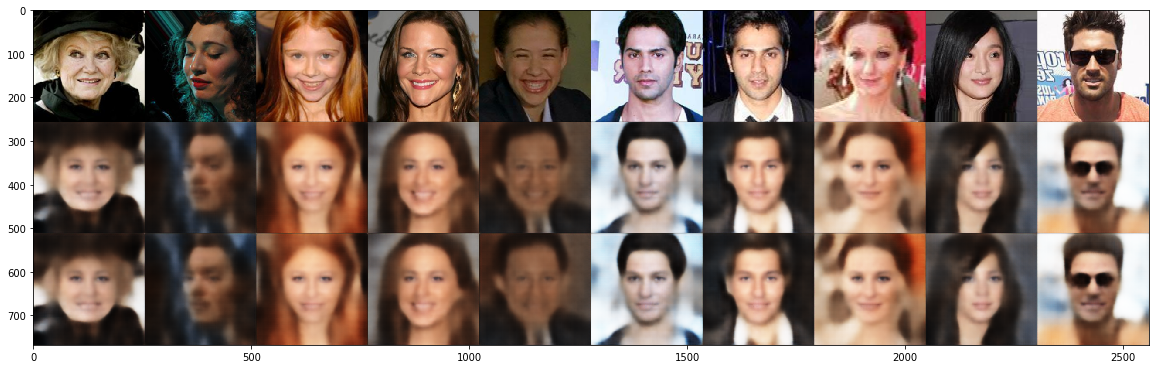

In [ ]:
global_step = 0
adversarial_lambda = 0.0
bce_history = []
mse_history = []
adv_history = []

for epoch in range(num_epoch):
    
    for (batch_img,batch_attr) in train_set:
        
        # Load batch
        input_img.data.copy_(batch_img)
        given_attr.data.copy_(batch_attr)
        flipped_attr.data.copy_(1-batch_attr)
        
        # Train Discriminator
        opt_dis.zero_grad()
        
        E_x = enc(input_img)
        pred_attr = dis(E_x.detach())
        dis_loss = classification_loss(pred_attr,given_attr)
        
        dis_loss.backward()
        opt_dis.step()
        
        # Train AE
        opt_enc_dec.zero_grad()

        pred_attr_to_fool = dis(E_x)
        reconstruct_img = dec(E_x,given_attr)
        
        adv_loss = classification_loss(pred_attr_to_fool,flipped_attr)
        rec_loss = reconstruct_loss(reconstruct_img,input_img)
        
        loss = rec_loss + adversarial_lambda*adv_loss
        
        loss.backward()
        
        opt_enc_dec.step()
        
        # End of step
        bce_history.append(dis_loss.cpu().data.numpy()[0])
        mse_history.append(rec_loss.cpu().data.numpy()[0])
        adv_history.append(adv_loss.cpu().data.numpy()[0])
        global_step += 1
        
        ### Increase Lambda
        if global_step < increase_step:
            adversarial_lambda += increase_lambda
        
        ### Display progress
        if global_step%display_step == 0:
            print(step_msg.format(epoch+1,global_step,np.mean(mse_history),np.mean(bce_history),np.mean(adv_history)),
                  end='\r',flush=True)
            bce_history = []
            mse_history = []
            adv_history = []
        
        ### Show result
        if global_step% plot_step ==0:
            # Run test
            for (batch_img,batch_attr) in debug_set:
                test_img.data.copy_(batch_img)
                test_attr.data.copy_(batch_attr)
                reconstruct_img = dec(enc(test_img),test_attr)
                
                test_attr.data.copy_(1-batch_attr)
                flipped_img = dec(enc(test_img),test_attr)
            # Show result
            tmp = []
            src_image = [(1+img)/2 for img in test_img.cpu().data.numpy().transpose(-4,-2,-1,-3)]
            rec_image = [(1+img)/2 for img in reconstruct_img.cpu().data.numpy().transpose(-4,-2,-1,-3)]
            flp_image = [(1+img)/2 for img in flipped_img.cpu().data.numpy().transpose(-4,-2,-1,-3)]
            tmp.append(np.concatenate(src_image,axis=-2))
            tmp.append(np.concatenate(rec_image,axis=-2))
            tmp.append(np.concatenate(flp_image,axis=-2))
            fig = plt.figure(figsize=(20, 10))
            tmp = np.squeeze(np.concatenate(tmp,axis=-3))
            plt.imshow(tmp)
            plt.show()
            if save_fig:
                plt.savefig(save_fig_path.format(global_step),bbox_inches='tight')
            plt.close()
        
        ### Save model
        if global_step % save_model_interval == 0:
            torch.save(enc,save_model_path+'.enc')
            torch.save(dec,save_model_path+'.dec')

# Remain part is dummy, ignore

In [126]:
attri_table['Smiling'].value_counts()

-1    104930
 1     97669
Name: Smiling, dtype: int64

In [57]:
attri_table.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')